# Import Library

In [1]:
import torch
import numpy as np
import pandas as pd
import re
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from transformers import T5Tokenizer, T5ForConditionalGeneration, Seq2SeqTrainingArguments
from transformers import Seq2SeqTrainer, DataCollatorForSeq2Seq, TrainerCallback, T5Config

from datasets import Dataset
from sklearn.model_selection import train_test_split

from torch.nn import CrossEntropyLoss
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from torch.amp import autocast  
import torch.nn.functional as F
from torch.utils.data import TensorDataset

from collections import defaultdict
warnings.filterwarnings("ignore")

# Cleaning Data

In [2]:
#Load Data
df = pd.read_csv('/kaggle/input/layoutlm/medquad.csv')

# Sampel Data
print("Data Sample")
print(df.head())

#Null value
print("Null Value Data")
print(df.isnull().sum())

duplicates = df.duplicated(['question'], keep=False).sum()
print(f"Total duplicates in 'question' column: {duplicates}")

# Check for duplicate rows

duplicates = df.duplicated()
print(f"Number of duplicate rows: {duplicates.sum()}")

# Remove duplicate rows
df = df.drop_duplicates()

# Reset the index after removing duplicates
df.reset_index(drop=True, inplace=True)

#Delete Unused column
df = df.drop(columns=['source', 'focus_area'])

#Table Info
print("Table Info")
print(df.info())

# Apply the function
df = df.drop_duplicates(subset='question', keep='first').reset_index(drop=True)
df = df.drop_duplicates(subset='answer', keep='first').reset_index(drop=True)

#Drop rows with null values
df.dropna(inplace=True)

#Checking again of null values
print("Null Value Data")
print(df.isnull().sum())

#Checking again of the data info
print(df.info())

#Check for Unique Data
print(f"Unique questions: {df['question'].nunique()}")
print(f"Unique answers: {df['answer'].nunique()}")

df['question'] = df['question'].str.lower().str.strip().apply(lambda x: re.sub(r'\s+', ' ', x))
df['answer'] = df['answer'].str.lower().str.strip().apply(lambda x: re.sub(r'\s+', ' ', x))
print(df.head())

Data Sample
                                 question  \
0                What is (are) Glaucoma ?   
1                  What causes Glaucoma ?   
2     What are the symptoms of Glaucoma ?   
3  What are the treatments for Glaucoma ?   
4                What is (are) Glaucoma ?   

                                              answer           source  \
0  Glaucoma is a group of diseases that can damag...  NIHSeniorHealth   
1  Nearly 2.7 million people have glaucoma, a lea...  NIHSeniorHealth   
2  Symptoms of Glaucoma  Glaucoma can develop in ...  NIHSeniorHealth   
3  Although open-angle glaucoma cannot be cured, ...  NIHSeniorHealth   
4  Glaucoma is a group of diseases that can damag...  NIHSeniorHealth   

  focus_area  
0   Glaucoma  
1   Glaucoma  
2   Glaucoma  
3   Glaucoma  
4   Glaucoma  
Null Value Data
question       0
answer         5
source         0
focus_area    14
dtype: int64
Total duplicates in 'question' column: 2319
Number of duplicate rows: 48
Table Info
<class 

# Architecting Model

In [3]:
# Load T5-small model and tokenizer
model_name = "t5-base"
config = T5Config.from_pretrained(model_name)
config.dropout_rate = 0.2
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name,config=config)

# Tie weights explicitly
model.resize_token_embeddings(len(tokenizer))

# Print model architecture summary
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("\nModel Summary:")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# Preprocess function for seq2seq task
def preprocess_function(batch):
    inputs = [
        f"question: {q} context: {c if 'context' in batch else ''} answer:"
        for q, c in zip(batch["question"], batch.get("context", [""] * len(batch["question"])))
    ]
    targets = [f"{a}" for a in batch["answer"]] 
    
    model_inputs = tokenizer(
        inputs,
        max_length=256,  
        truncation=True,
        padding="max_length",
        return_tensors="pt",
    )

    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            targets,
            max_length=128,  
            truncation=True,
            padding="max_length",
            return_tensors="pt",
        )

    labels["input_ids"][labels["input_ids"] == tokenizer.pad_token_id] = -100
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# Train-test split
train_df, val_df = train_test_split(df, test_size=0.15, random_state=42)

# Convert to Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

# Preprocess datasets
train_dataset = train_dataset.map(
    preprocess_function,
    batched=True,
    batch_size=32,  
    remove_columns=train_dataset.column_names,
    num_proc=4,   
)

val_dataset = val_dataset.map(
    preprocess_function,
    batched=True,
    batch_size=32,  
    remove_columns=val_dataset.column_names,
    num_proc=4,  
)


# Training arguments
training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    evaluation_strategy="steps",
    eval_steps=500,  
    save_steps=500,  
    save_total_limit=2,  
    learning_rate=3e-4,   
    num_train_epochs=5,   
    per_device_train_batch_size=16,   
    per_device_eval_batch_size=16, 
    lr_scheduler_type="linear",  
    warmup_ratio=0.1,  
    weight_decay=0.05,
    predict_with_generate=True,
    fp16=True,   
    logging_dir="./logs",
    logging_steps=50,  
    load_best_model_at_end=True,
    metric_for_best_model="validation_accuracy",
    greater_is_better=True,
    report_to="none",
    gradient_accumulation_steps=1,   
    max_grad_norm=0.5,
    optim="adamw_torch_fused",  
    generation_max_length=64,  
    generation_num_beams=4,
    dataloader_num_workers=4,   
    group_by_length=True, 
    remove_unused_columns=True,
)

training_args.label_smoothing_factor = 0.1
data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer, 
    model=model,  
    padding='longest',  
)

# Create function to show accuracy and validation accuracy
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    
    if isinstance(predictions, tuple):
        predictions = predictions[0]
    
    # Decode predictions and labels
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    # Replace -100 with pad token id
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    
    def normalize_text(text):
        # More comprehensive text normalization
        text = text.strip().lower()
        text = re.sub(r'\s+', ' ', text) 
        text = re.sub(r'[^\w\s]', '', text)  
        return text
    
    decoded_preds = [normalize_text(pred) for pred in decoded_preds]
    decoded_labels = [normalize_text(label) for label in decoded_labels]
    
    # Calculate exact match and word-level accuracy
    exact_matches = [pred == label for pred, label in zip(decoded_preds, decoded_labels)]
    exact_match_accuracy = np.mean(exact_matches)
    
    def word_overlap_score(pred, label):
        pred_words = set(pred.split())
        label_words = set(label.split())
        if not label_words:
            return 0.0
        return len(pred_words.intersection(label_words)) / len(label_words)
    
    word_scores = [word_overlap_score(pred, label) 
                  for pred, label in zip(decoded_preds, decoded_labels)]
    
    return {
        "accuracy": exact_match_accuracy,
        "validation_accuracy": np.mean(word_scores),
    }


# Initialize data collator
data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    model=model,
    padding='longest',
    return_tensors="pt"
)

# Initialize trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

# Train the model
trainer.train()

# Save the model and tokenizer
trainer.save_model("./t5_chatbot_model")
tokenizer.save_pretrained("./t5_chatbot_tokenizer")
model_path = "./t5_chatbot_model.h5"
torch.save(model.state_dict(), model_path)

# Save log history
log_history = trainer.state.log_history


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]


Model Summary:
Total parameters: 222,882,048
Trainable parameters: 222,882,048


Map (num_proc=4):   0%|          | 0/12293 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/2170 [00:00<?, ? examples/s]

Step,Training Loss,Validation Loss,Accuracy,Validation Accuracy
500,3.347700,3.160073,0.001382,0.259017
1000,3.203800,3.064682,0.000461,0.269037
1500,3.156400,3.026470,0.000461,0.272234


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


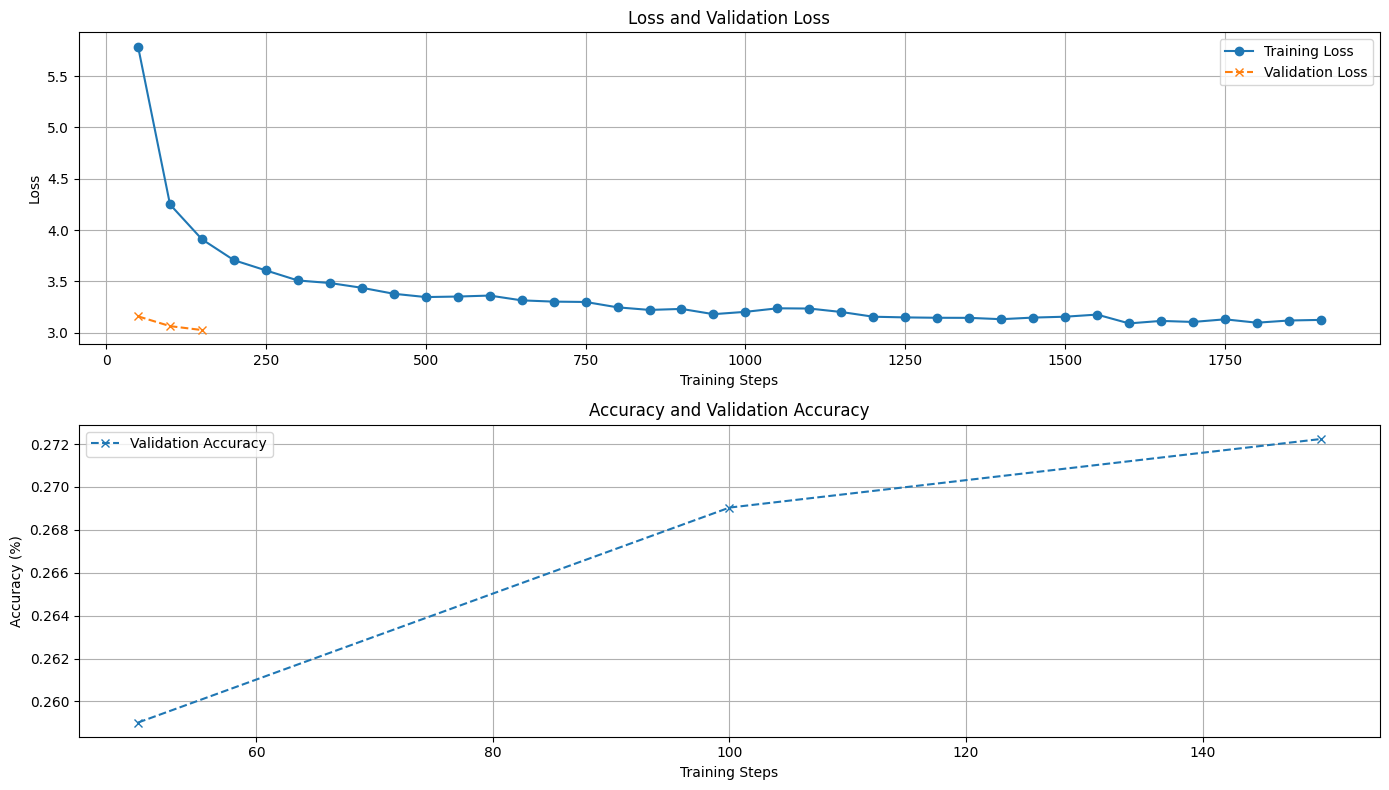

In [4]:
steps = []
training_loss = []
validation_loss = []
accuracy = []
validation_accuracy = []
# Parse log history to extract relevant metrics
for entry in log_history:
    if "loss" in entry:
        steps.append(entry["step"])
        training_loss.append(entry["loss"])
    if "eval_loss" in entry:
        validation_loss.append(entry["eval_loss"])
    if "accuracy" in entry:
        accuracy.append(entry["accuracy"])
    if "eval_validation_accuracy" in entry:
        validation_accuracy.append(entry["eval_validation_accuracy"])

# Plot metrics
plt.figure(figsize=(14, 8))

# Subplot 1: Loss vs Validation Loss
plt.subplot(2, 1, 1)
plt.plot(steps[:len(training_loss)], training_loss, label="Training Loss", marker="o", linestyle="-")
if validation_loss:
    plt.plot(steps[:len(validation_loss)], validation_loss, label="Validation Loss", marker="x", linestyle="--")
plt.title("Loss and Validation Loss")
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# Subplot 2: Accuracy vs Validation Accuracy
plt.subplot(2, 1, 2)
if accuracy:
    plt.plot(steps[:len(accuracy)], accuracy, label="Training Accuracy", marker="o", linestyle="-")
if validation_accuracy:
    plt.plot(steps[:len(validation_accuracy)], validation_accuracy, label="Validation Accuracy", marker="x", linestyle="--")
plt.title("Accuracy and Validation Accuracy")
plt.xlabel("Training Steps")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)

# Show the plots
plt.tight_layout()
plt.show()

# Testing using Input

In [8]:
# Load the trained T5 model and tokenizer
model_path = "/kaggle/working/t5_chatbot_model"
tokenizer_path = "/kaggle/working/t5_chatbot_tokenizer"

tokenizer = T5Tokenizer.from_pretrained(tokenizer_path)
model = T5ForConditionalGeneration.from_pretrained(model_path)
model.eval() 

def generate_response(question):
    input_ids = tokenizer(f"question: {question} </s>", return_tensors="pt").input_ids.to(model.device)
    outputs = model.generate(
        input_ids,
        max_length=128,
        num_beams=5,  
        no_repeat_ngram_size=2,  
        top_k=50,  
        top_p=0.95,  
        temperature=1.0  
    )
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

# Example usage
response = generate_response("What is Paget's Disease of Bone ?")
print(response)

Paget's Disease of Bone (pdb) is a condition that affects the bones of the body. it is caused by mutations in the ptb gene. this gene provides instructions for making an enzyme that helps break down bone cells. the enzyme is involved in breaking down and dividing bone, which leads to the formation of bone marrow. in some cases, the protein is broken down to form bone. other cases result from changes (mutations) in one or more of these genes. these cases are inherited in an autosomal recessive manner.
